## [02] CAM을 만들고 평가해 보자


### rubric
1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가? ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.
2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가? CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.
3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가? CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.


### 실습목표

- Classification model로부터 CAM을 얻어낼 수 있다.
- CAM으로 물체의 위치를 찾을 수 있다.
- CAM을 시각화 비교할 수 있다.



## Part1. preparation

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [3]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# dataset: stanford_dogs
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete35HO78/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete35HO78/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


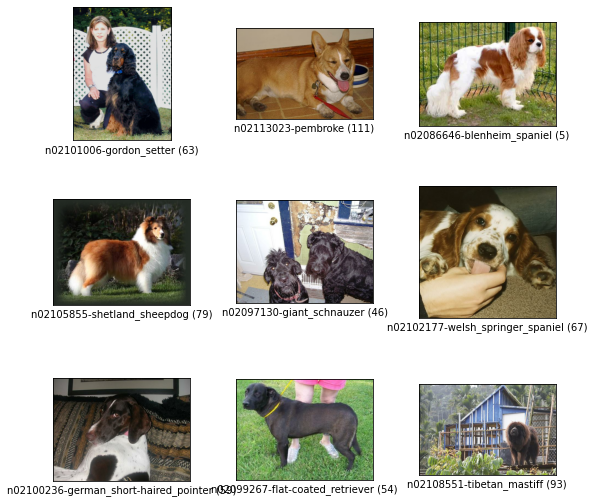

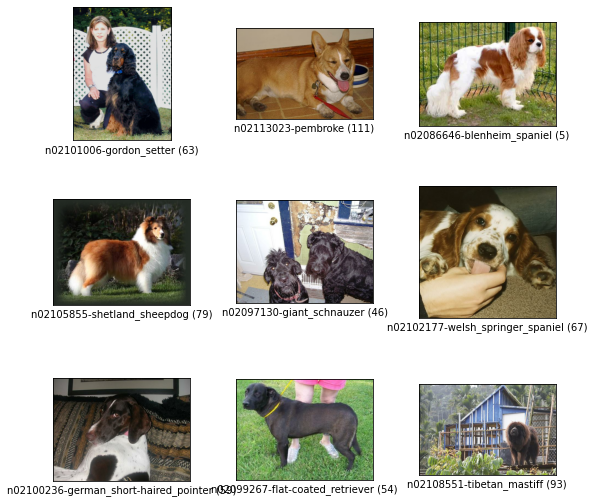

In [6]:
# train image check

tfds.show_examples(ds_train, ds_info)

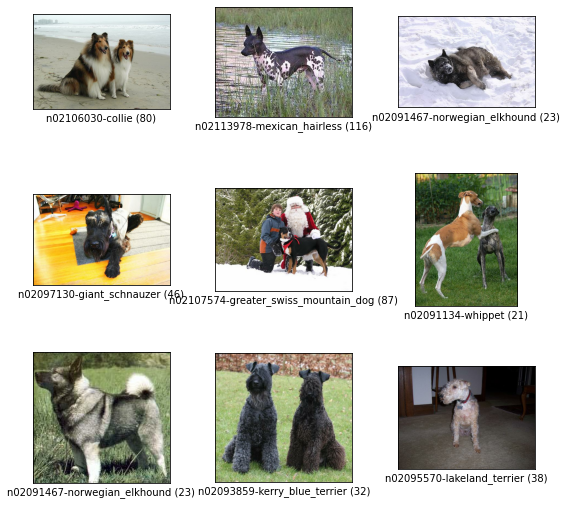

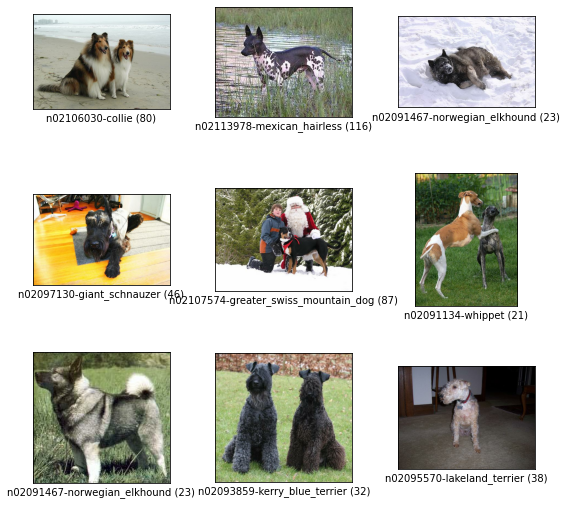

In [7]:
# test image check

tfds.show_examples(ds_test, ds_info)

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [9]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50( # resnet50을 기반으로 
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # fully connected layer 대신 GAP을 적용
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 2s 0us/step


In [10]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [12]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [13]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


In [15]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 122s 153ms/step - loss: 2.1829 - accuracy: 0.4548 - val_loss: 3.3428 - val_accuracy: 0.2136
Epoch 2/10
750/750 [==============================] - 111s 148ms/step - loss: 0.7235 - accuracy: 0.8001 - val_loss: 1.1075 - val_accuracy: 0.6774
Epoch 3/10
750/750 [==============================] - 122s 163ms/step - loss: 0.2439 - accuracy: 0.9468 - val_loss: 0.9666 - val_accuracy: 0.7168
Epoch 4/10
750/750 [==============================] - 104s 139ms/step - loss: 0.0940 - accuracy: 0.9892 - val_loss: 0.9144 - val_accuracy: 0.7332
Epoch 5/10
750/750 [==============================] - 118s 158ms/step - loss: 0.0294 - accuracy: 0.9980 - val_loss: 0.8823 - val_accuracy: 0.7479
Epoch 6/10
750/750 [==============================] - 101s 135ms/step - loss: 0.0136 - accuracy: 0.9998 - val_loss: 0.8850 - val_accuracy: 0.7477
Epoch 7/10
750/750 [==============================] - 101s 135ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.9243 -

In [18]:
cam_model_path = '/content/drive/MyDrive/Colab Notebooks/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료👏")

저장 완료👏


## Part2. CAM 구현


In [19]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [20]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


108


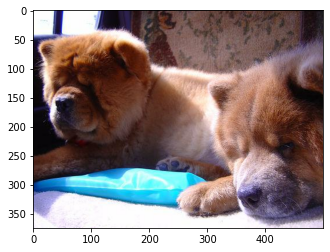

In [21]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [23]:
cam_model_path = '/content/drive/MyDrive/Colab Notebooks/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


In [24]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')

슝=3


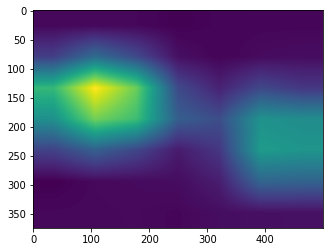

In [25]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [26]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


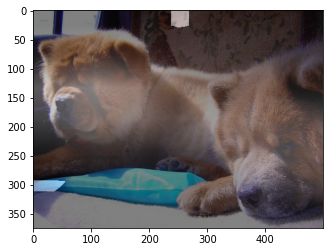

In [27]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## part3. Grad-CAM 구현

108


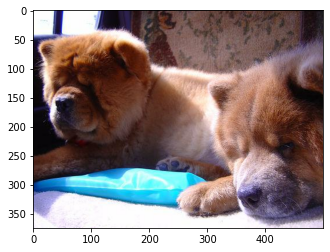

In [28]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [29]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널 값과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


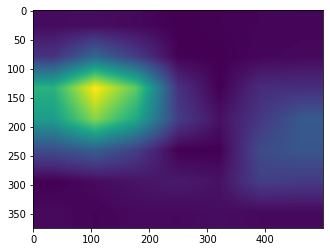

In [30]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

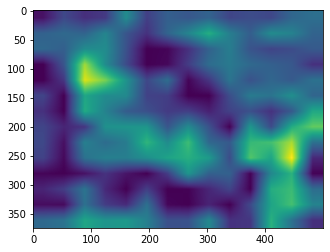

In [31]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

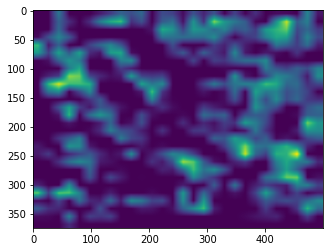

In [32]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

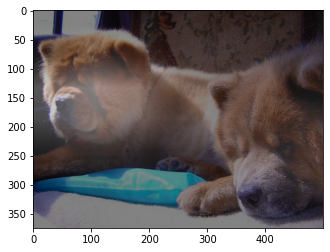

In [33]:
# cam on image
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Part4. 바운딩 박스 구하기

40


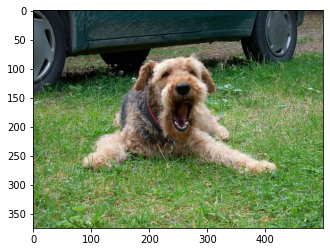

In [34]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

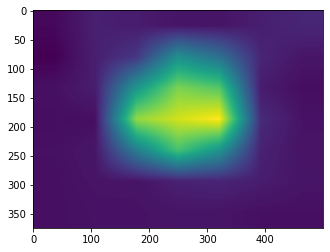

In [35]:
# 이전 스텝에서 만들었던 generate_cam()을 활용해서 CAM 이미지를 뽑기

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [36]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


In [37]:
rect = get_bbox(cam_image)
rect

array([[109, 306],
       [109,   0],
       [498,   0],
       [498, 306]])

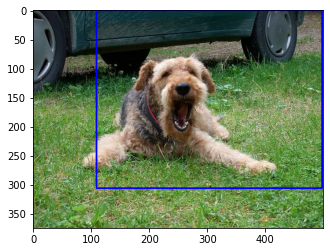

In [38]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## Part5. IoU 구하기

In [39]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


In [40]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.218, 0.816, 0.996]

In [41]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

In [43]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


In [44]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5309627331230234

## Part6. CAM과 Grad-CAM 성능비교

67


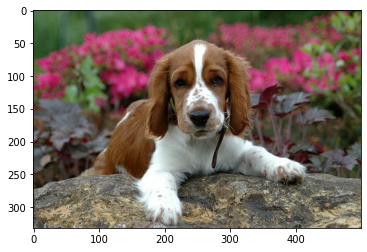

In [45]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

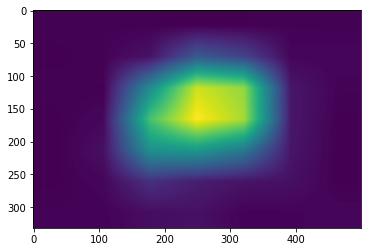

In [46]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [47]:
rect = get_bbox(cam_image)
rect

array([[113, 300],
       [101,  39],
       [395,  26],
       [406, 287]])

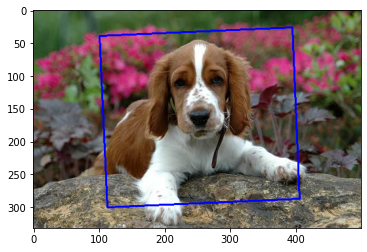

In [48]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [49]:
# IoU
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7623878999055144

#### Grad-CAM

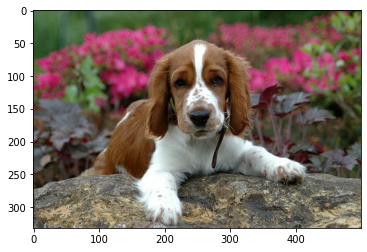

In [50]:
plt.imshow(item['image'])
plt.show()

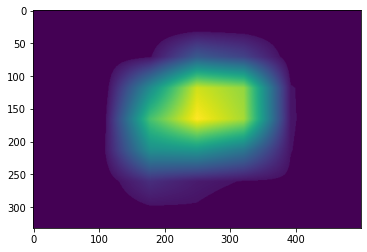

In [51]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(cam_image)
plt.show()

In [52]:
rect = get_bbox(grad_cam_image,)
rect

array([[175, 331],
       [175, 305],
       [183, 305],
       [183, 331]])

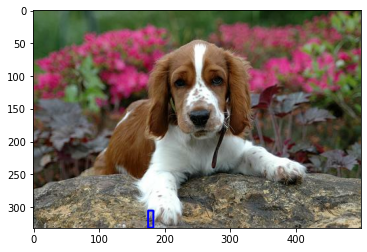

In [53]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [54]:
# IoU
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.0019118077521346666

## Trial and error

우선 lou점수가 grad_cam에서 좋지 못한 결과가 나왔지만 cam 자체 점수는 좋은 점수를 받아 다시 진행하지 않았다. CAM은 본인에게 시작부터 어려웠던 주제로 이게 무슨말이야 싶어서 공부하기 싫었던 기억이난다. 그럼에도 무사히 끝낼 수 있어서 다행인 노드. 